/tmp/ipython-input-1-344858939.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model for 100 epochs...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1144 - val_loss: 3.3151e-04
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0024 - val_loss: 3.7205e-04
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0013 - val_loss: 6.7298e-04
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 9.8318e-04 - val_loss: 3.5677e-04
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 8.3186e-04 - val_loss: 3.6442e-04
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 8.5698e-04 - val_loss: 2.6716e-04
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 8.3693e-04 - val_loss: 3.4642e-04
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.9942e-04 - val_loss: 2.6368e-04
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.6626e-04 - val_loss: 3.8842e-04
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 7.5486e-04 - val_loss: 2.7387e-04
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━

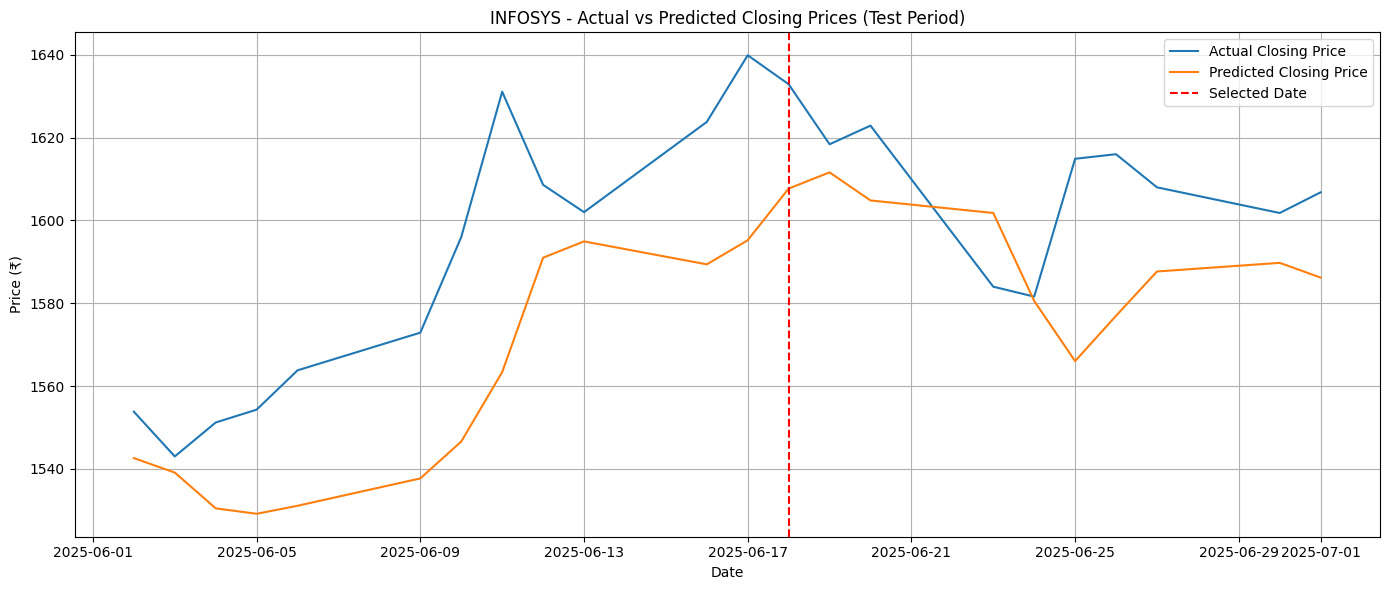

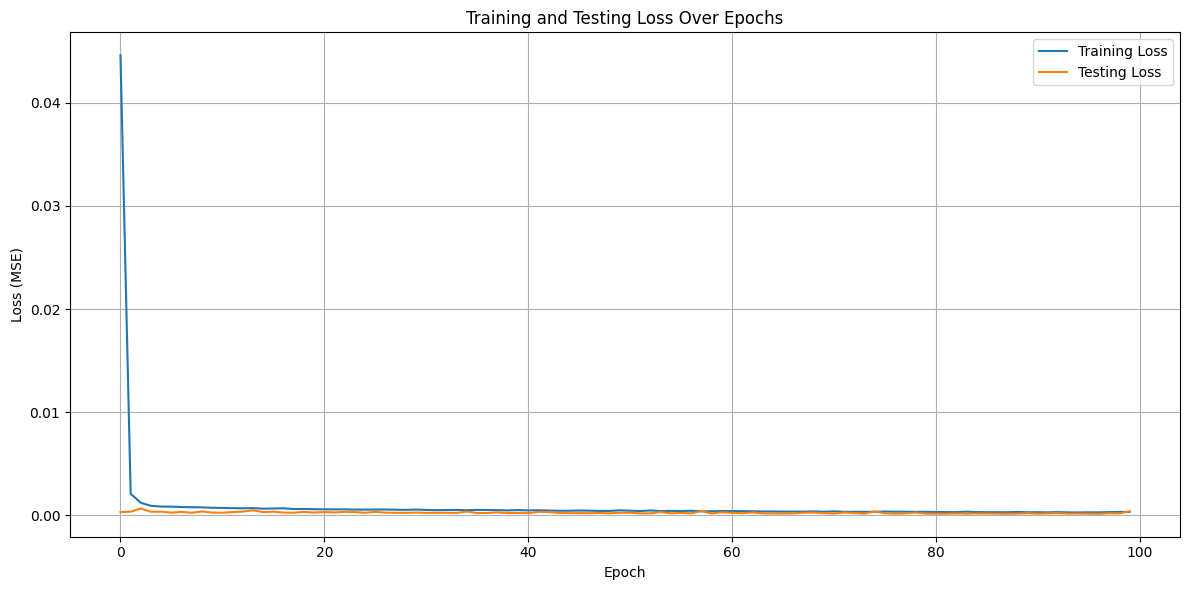

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# For reproducibility
np.random.seed(42)

# Download data
print("Downloading INFOSYS historical data...")
df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")

if df.empty:
    print("ERROR: No data returned.")
    exit()

# Use only Close price
df = df[["Close"]]
df.reset_index(inplace=True)
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values("Date", inplace=True)

# Split train/test
train_df = df[df["Date"] <= date(2025, 5, 31)]
test_df = df[(df["Date"] >= date(2025, 6, 1)) & (df["Date"] <= date(2025, 7, 1))]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Determine split index
# The split index needs to account for the sequence length offset
# It should align with the original train_df length minus the sequence length
# because X and y are created from the *entire* scaled_close data.
# The `split_index` should correspond to the number of sequences that can be formed
# entirely within the `train_df`'s date range.
# Let's recalculate `split_index` based on the number of training samples after sequence creation.
# The number of samples in X_train should correspond to the number of `y` values
# that fall within the `train_df`'s date range, considering the `sequence_length` offset.

# Find the index in the original `df` where the test data starts
# This is `len(train_df)` in the original `df` indices.
# However, `X` and `y` are shifted by `sequence_length`.
# So, the split_index for X and y should be `len(train_df) - sequence_length`.
# This ensures X_train contains sequences ending up to the last day of train_df.
split_index = len(train_df) - sequence_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
test_dates = df["Date"].values[sequence_length + split_index:] # Dates corresponding to y_test

# Build LSTM model
model = Sequential()
# Changed SimpleRNN to LSTM
model.add(LSTM(50, activation="tanh", input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train model with validation on test data
print("Training model for 100 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    # Check if the user_date is present in the test_dates array
    if user_date not in test_dates:
        print("Date not in test data. Please choose a date from the available test dates.")
        print(f"Available test dates: {test_dates[0]} to {test_dates[-1]}")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3-1054187199.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")
[*********************100%***********************]  1 of 1 completed

Training model for 500 epochs...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.2029 - val_loss: 0.0046
Epoch 2/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0031 - val_loss: 2.9071e-04
Epoch 3/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 4/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013 - val_loss: 4.4806e-04
Epoch 5/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0010 - val_loss: 4.7775e-04
Epoch 6/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0011 - val_loss: 7.1043e-04
Epoch 7/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011 - val_loss: 4.3731e-04
Epoch 8/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.2920e-04 - val_loss: 6.9184e-04
Epoch 9/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 9.7383e-04 - val_loss: 4.4767e-04
Epoch 10/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.7414e-04 - val_loss: 3.9799e-04
Epoch 11/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.4929e-04 - val_loss: 4.5453e-04


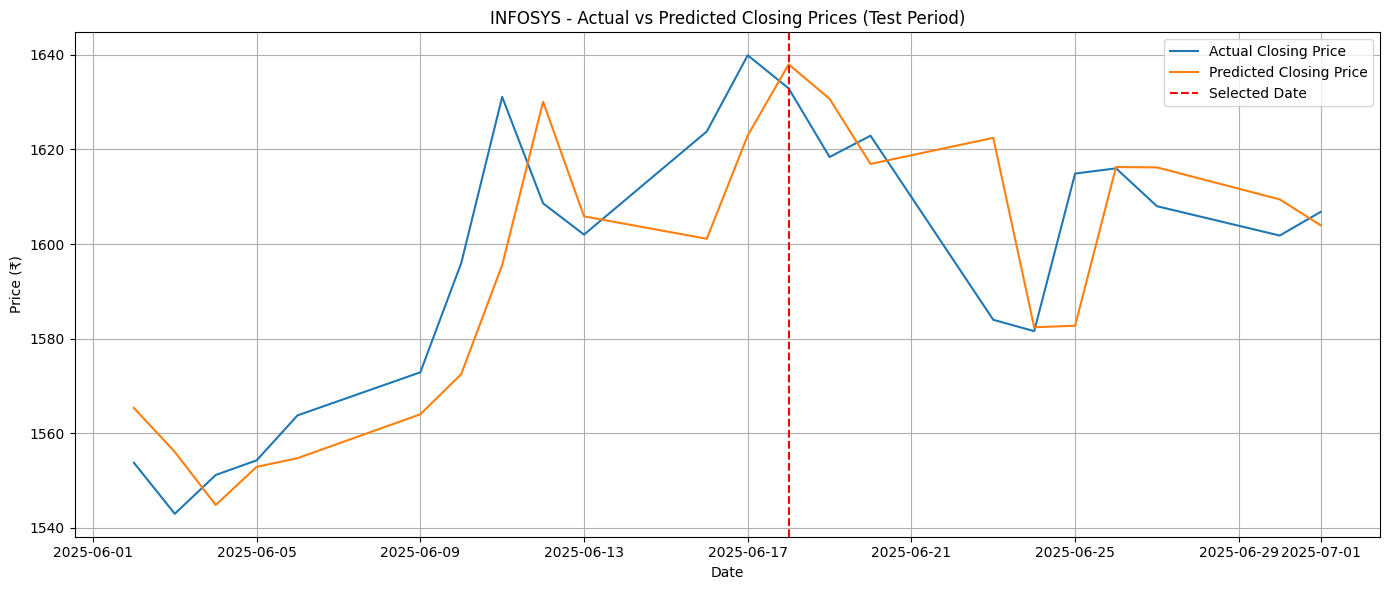

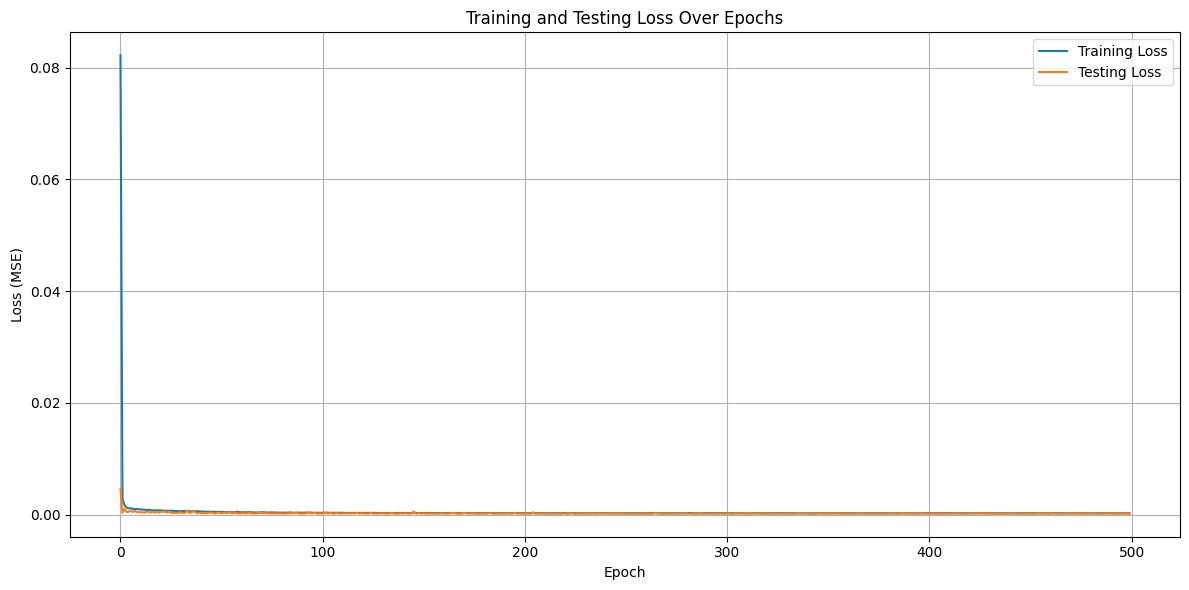

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# For reproducibility
np.random.seed(42)

# Download data
print("Downloading INFOSYS historical data...")
df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")

if df.empty:
    print("ERROR: No data returned.")
    exit()

# Use only Close price
df = df[["Close"]]
df.reset_index(inplace=True)
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values("Date", inplace=True)

# Split train/test
train_df = df[df["Date"] <= date(2025, 5, 31)]
test_df = df[(df["Date"] >= date(2025, 6, 1)) & (df["Date"] <= date(2025, 7, 1))]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Determine split index
# The split index needs to account for the sequence length offset
# It should align with the original train_df length minus the sequence length
# because X and y are created from the *entire* scaled_close data.
# The `split_index` should correspond to the number of sequences that can be formed
# entirely within the `train_df`'s date range.
# Let's recalculate `split_index` based on the number of training samples after sequence creation.
# The number of samples in X_train should correspond to the number of `y` values
# that fall within the `train_df`'s date range, considering the `sequence_length` offset.

# Find the index in the original `df` where the test data starts
# This is `len(train_df)` in the original `df` indices.
# However, `X` and `y` are shifted by `sequence_length`.
# So, the split_index for X and y should be `len(train_df) - sequence_length`.
# This ensures X_train contains sequences ending up to the last day of train_df.
split_index = len(train_df) - sequence_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
test_dates = df["Date"].values[sequence_length + split_index:] # Dates corresponding to y_test

# Build LSTM model
model = Sequential()
# Changed SimpleRNN to LSTM
model.add(LSTM(50, activation="tanh", input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train model with validation on test data
print("Training model for 500 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    # Check if the user_date is present in the test_dates array
    if user_date not in test_dates:
        print("Date not in test data. Please choose a date from the available test dates.")
        print(f"Available test dates: {test_dates[0]} to {test_dates[-1]}")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-4-4138405439.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")
[*********************100%***********************]  1 of 1 completed

Training model for 1000 epochs...
Epoch 1/1000



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1632 - val_loss: 0.0061
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0024 - val_loss: 3.6135e-04
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015 - val_loss: 6.1174e-04
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - val_loss: 3.7900e-04
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 9.7797e-04 - val_loss: 3.6141e-04
Epoch 6/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.2595e-04 - val_loss: 2.6737e-04
Epoch 7/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.1527e-04 - val_loss: 3.8961e-04
Epoch 8/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.9722e-04 - val_loss: 4.1863e-04
Epoch 9/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.3313e-04 - val_loss: 3.6936e-04
Epoch 10/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.9578e-04 - val_loss: 3.0628e-04
Epoch 11/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.1577e-04 - val_los

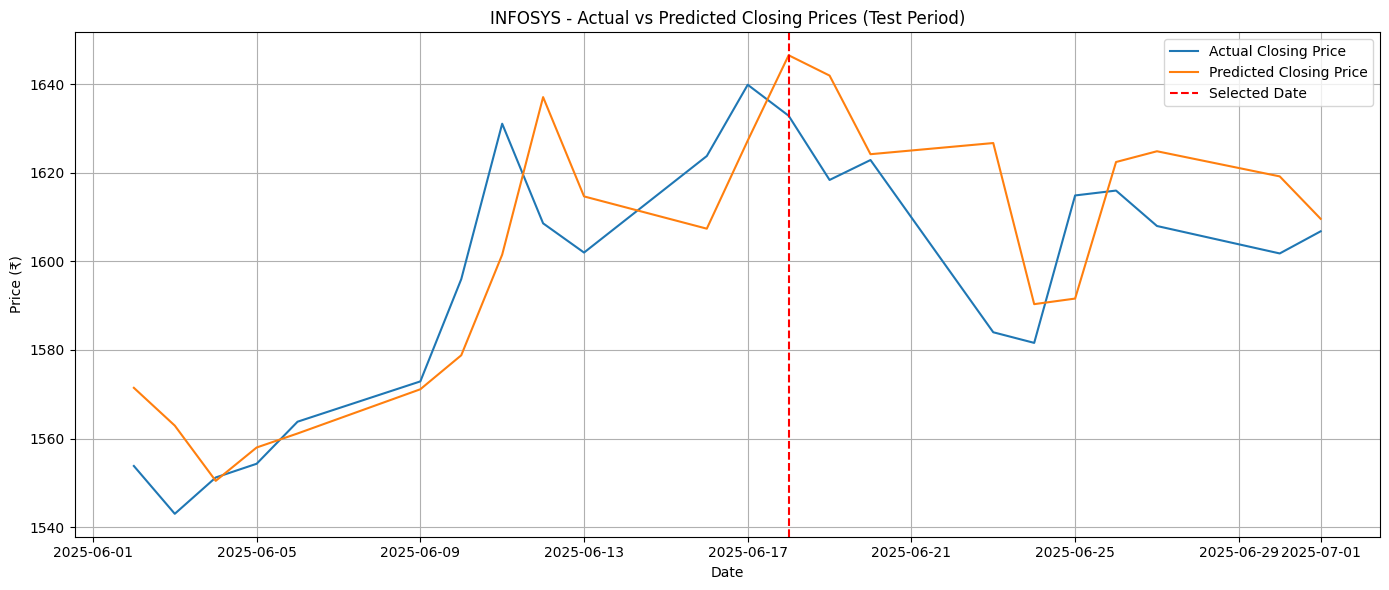

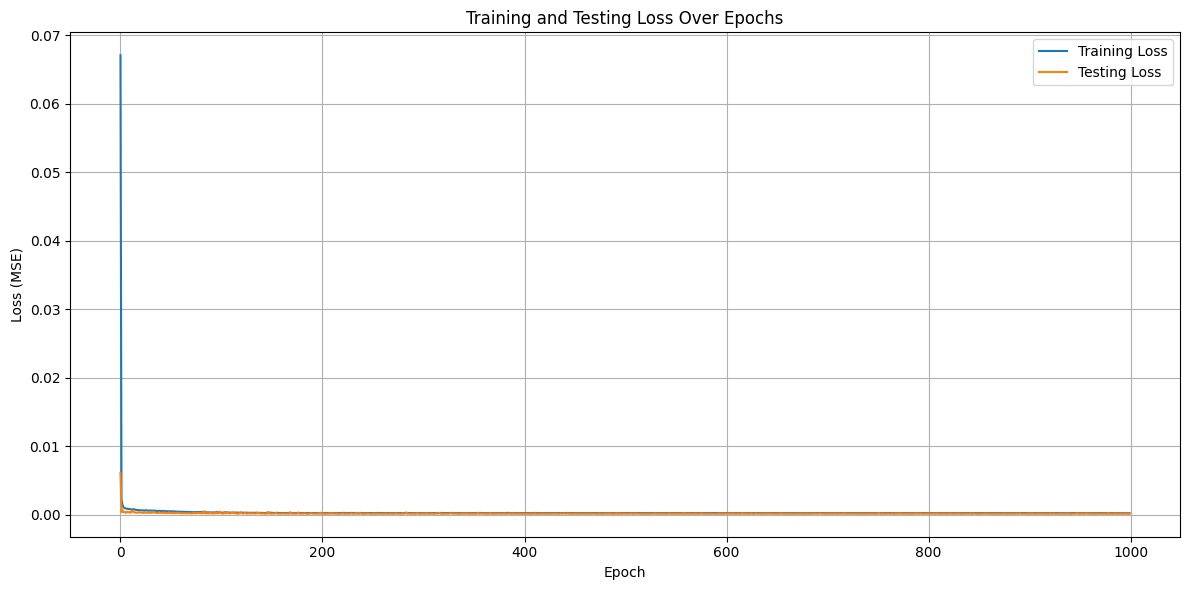

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# For reproducibility
np.random.seed(42)

# Download data
print("Downloading INFOSYS historical data...")
df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")

if df.empty:
    print("ERROR: No data returned.")
    exit()

# Use only Close price
df = df[["Close"]]
df.reset_index(inplace=True)
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values("Date", inplace=True)

# Split train/test
train_df = df[df["Date"] <= date(2025, 5, 31)]
test_df = df[(df["Date"] >= date(2025, 6, 1)) & (df["Date"] <= date(2025, 7, 1))]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Determine split index
# The split index needs to account for the sequence length offset
# It should align with the original train_df length minus the sequence length
# because X and y are created from the *entire* scaled_close data.
# The `split_index` should correspond to the number of sequences that can be formed
# entirely within the `train_df`'s date range.
# Let's recalculate `split_index` based on the number of training samples after sequence creation.
# The number of samples in X_train should correspond to the number of `y` values
# that fall within the `train_df`'s date range, considering the `sequence_length` offset.

# Find the index in the original `df` where the test data starts
# This is `len(train_df)` in the original `df` indices.
# However, `X` and `y` are shifted by `sequence_length`.
# So, the split_index for X and y should be `len(train_df) - sequence_length`.
# This ensures X_train contains sequences ending up to the last day of train_df.
split_index = len(train_df) - sequence_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
test_dates = df["Date"].values[sequence_length + split_index:] # Dates corresponding to y_test

# Build LSTM model
model = Sequential()
# Changed SimpleRNN to LSTM
model.add(LSTM(50, activation="tanh", input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train model with validation on test data
print("Training model for 1000 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    # Check if the user_date is present in the test_dates array
    if user_date not in test_dates:
        print("Date not in test data. Please choose a date from the available test dates.")
        print(f"Available test dates: {test_dates[0]} to {test_dates[-1]}")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-5-3106308660.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model for 2000 epochs...
Epoch 1/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1724 - val_loss: 0.0022
Epoch 2/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0034 - val_loss: 5.9135e-04
Epoch 3/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0019 - val_loss: 3.9461e-04
Epoch 4/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013 - val_loss: 5.2469e-04
Epoch 5/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0010 - val_loss: 4.7871e-04
Epoch 6/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0011 - val_loss: 3.4799e-04
Epoch 7/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.4198e-04 - val_loss: 4.9385e-04
Epoch 8/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.7863e-04 - val_loss: 4.7385e-04
Epoch 9/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.9413e-04 - val_loss: 3.3283e-04
Epoch 10/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.5430e-04 - val_loss: 4.9933e-04
Epoch 11/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s

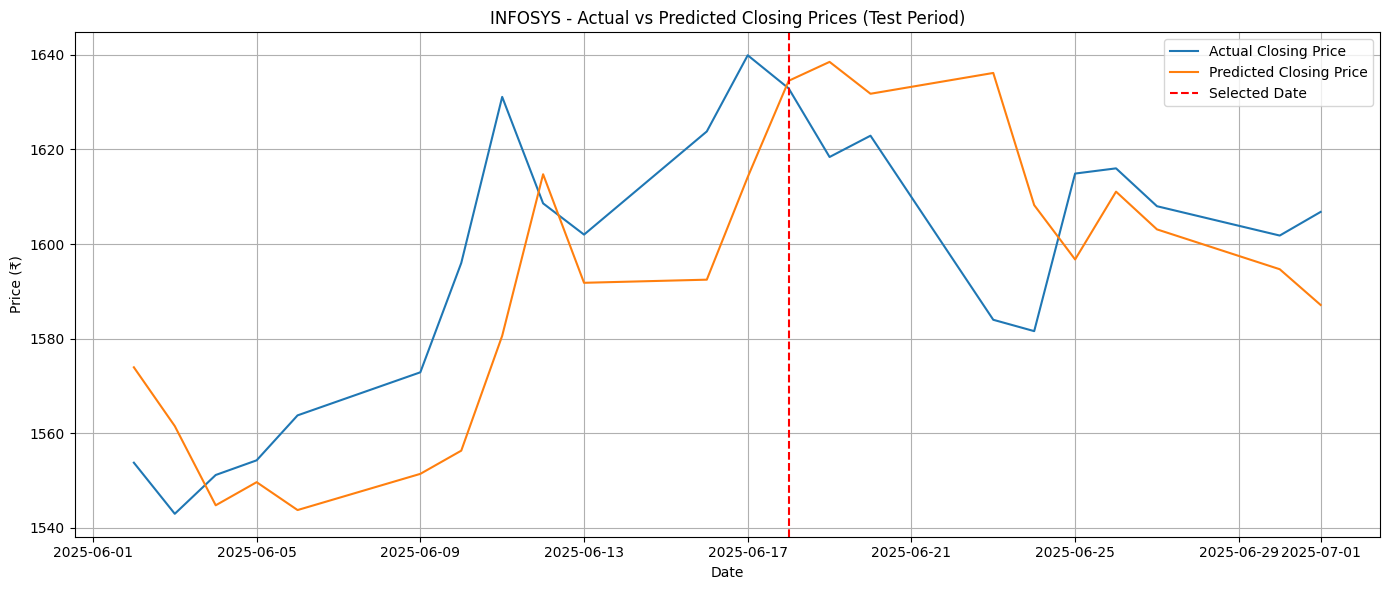

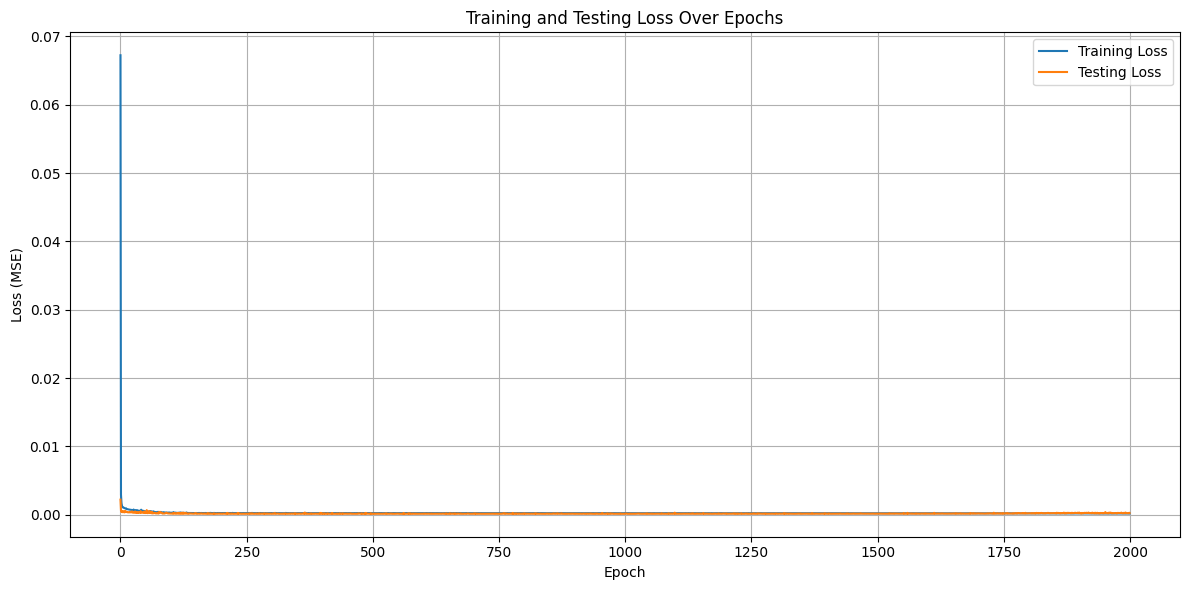

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# For reproducibility
np.random.seed(42)

# Download data
print("Downloading INFOSYS historical data...")
df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")

if df.empty:
    print("ERROR: No data returned.")
    exit()

# Use only Close price
df = df[["Close"]]
df.reset_index(inplace=True)
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values("Date", inplace=True)

# Split train/test
train_df = df[df["Date"] <= date(2025, 5, 31)]
test_df = df[(df["Date"] >= date(2025, 6, 1)) & (df["Date"] <= date(2025, 7, 1))]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Determine split index
# The split index needs to account for the sequence length offset
# It should align with the original train_df length minus the sequence length
# because X and y are created from the *entire* scaled_close data.
# The `split_index` should correspond to the number of sequences that can be formed
# entirely within the `train_df`'s date range.
# Let's recalculate `split_index` based on the number of training samples after sequence creation.
# The number of samples in X_train should correspond to the number of `y` values
# that fall within the `train_df`'s date range, considering the `sequence_length` offset.

# Find the index in the original `df` where the test data starts
# This is `len(train_df)` in the original `df` indices.
# However, `X` and `y` are shifted by `sequence_length`.
# So, the split_index for X and y should be `len(train_df) - sequence_length`.
# This ensures X_train contains sequences ending up to the last day of train_df.
split_index = len(train_df) - sequence_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
test_dates = df["Date"].values[sequence_length + split_index:] # Dates corresponding to y_test

# Build LSTM model
model = Sequential()
# Changed SimpleRNN to LSTM
model.add(LSTM(50, activation="tanh", input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train model with validation on test data
print("Training model for 2000 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=2000,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    # Check if the user_date is present in the test_dates array
    if user_date not in test_dates:
        print("Date not in test data. Please choose a date from the available test dates.")
        print(f"Available test dates: {test_dates[0]} to {test_dates[-1]}")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# For reproducibility
np.random.seed(42)

# Download data
print("Downloading INFOSYS historical data...")
df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")

if df.empty:
    print("ERROR: No data returned.")
    exit()

# Use only Close price
df = df[["Close"]]
df.reset_index(inplace=True)
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values("Date", inplace=True)

# Split train/test
train_df = df[df["Date"] <= date(2025, 5, 31)]
test_df = df[(df["Date"] >= date(2025, 6, 1)) & (df["Date"] <= date(2025, 7, 1))]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Determine split index
# The split index needs to account for the sequence length offset
# It should align with the original train_df length minus the sequence length
# because X and y are created from the *entire* scaled_close data.
# The `split_index` should correspond to the number of sequences that can be formed
# entirely within the `train_df`'s date range.
# Let's recalculate `split_index` based on the number of training samples after sequence creation.
# The number of samples in X_train should correspond to the number of `y` values
# that fall within the `train_df`'s date range, considering the `sequence_length` offset.

# Find the index in the original `df` where the test data starts
# This is `len(train_df)` in the original `df` indices.
# However, `X` and `y` are shifted by `sequence_length`.
# So, the split_index for X and y should be `len(train_df) - sequence_length`.
# This ensures X_train contains sequences ending up to the last day of train_df.
split_index = len(train_df) - sequence_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
test_dates = df["Date"].values[sequence_length + split_index:] # Dates corresponding to y_test

# Build LSTM model
model = Sequential()
# Changed SimpleRNN to LSTM
model.add(LSTM(50, activation="tanh", input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train model with validation on test data
print("Training model for 5000 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=5000,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    # Check if the user_date is present in the test_dates array
    if user_date not in test_dates:
        print("Date not in test data. Please choose a date from the available test dates.")
        print(f"Available test dates: {test_dates[0]} to {test_dates[-1]}")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-6-4124926120.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")
[*********************100%***********************]  1 of 1 completed

Training model for 5000 epochs...
Epoch 1/5000



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Streaming output truncated to the last 5000 lines.
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.6048e-04 - val_loss: 1.5913e-04
Epoch 2475/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.6342e-04 - val_loss: 1.5142e-04
Epoch 2476/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.5596e-04 - val_loss: 1.6210e-04
Epoch 2477/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.7284e-04 - val_loss: 1.8037e-04
Epoch 2478/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.7141e-04 - val_loss: 1.4713e-04
Epoch 2479/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.7081e-04 - val_loss: 1.7544e-04
Epoch 2480/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.3872e-04 - val_loss: 1.4489e-04
Epoch 2481/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.7495e-04 - val_loss: 1.6590e-04
Epoch 2482/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.5761e-04 - val_loss: 1.5316e-04
Epoch 2483/5000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.6268e-04 - val_lo

/tmp/ipython-input-7-1611704281.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Streaming output truncated to the last 5000 lines.
Epoch 5011/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.3620e-05 - val_loss: 0.0010
Epoch 5012/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.3817e-05 - val_loss: 0.0010
Epoch 5013/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.1787e-05 - val_loss: 0.0010
Epoch 5014/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.4668e-05 - val_loss: 9.5291e-04
Epoch 5015/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.7699e-05 - val_loss: 0.0011
Epoch 5016/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.2820e-05 - val_loss: 0.0011
Epoch 5017/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.5038e-05 - val_loss: 0.0010
Epoch 5018/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.3346e-05 - val_loss: 9.6692e-04
Epoch 5019/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.5567e-05 - val_loss: 9.9969e-04
Epoch 5020/7500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.3587e-05 - val_loss: 0.00

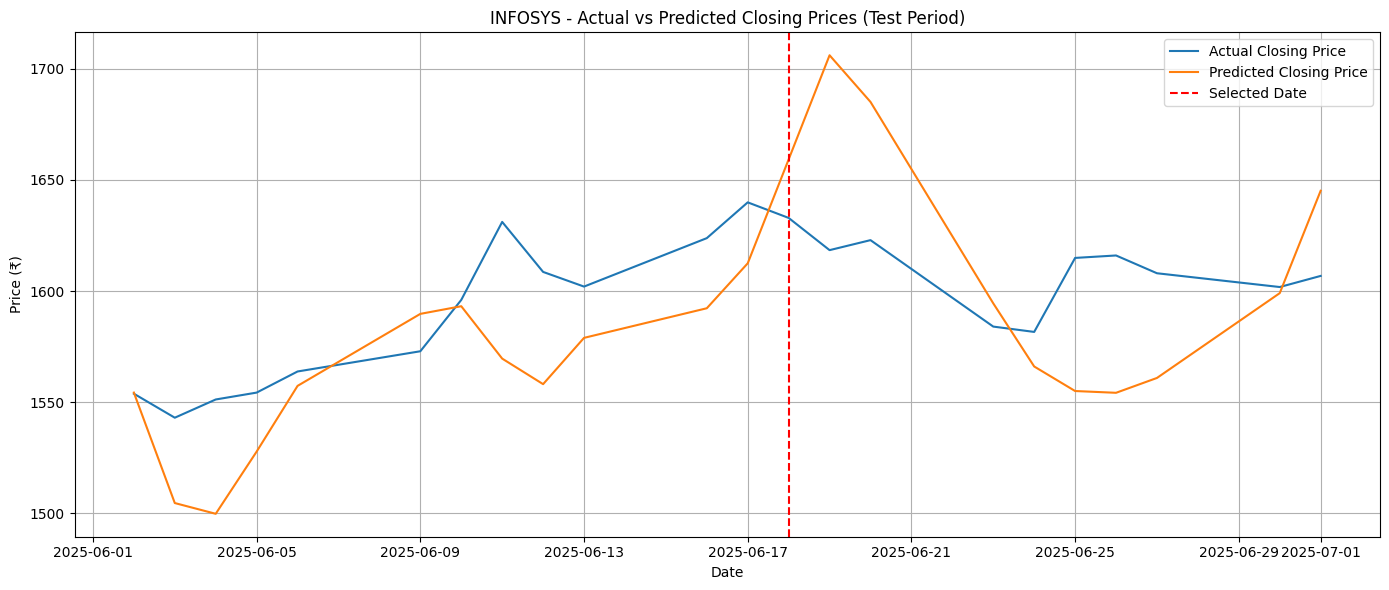

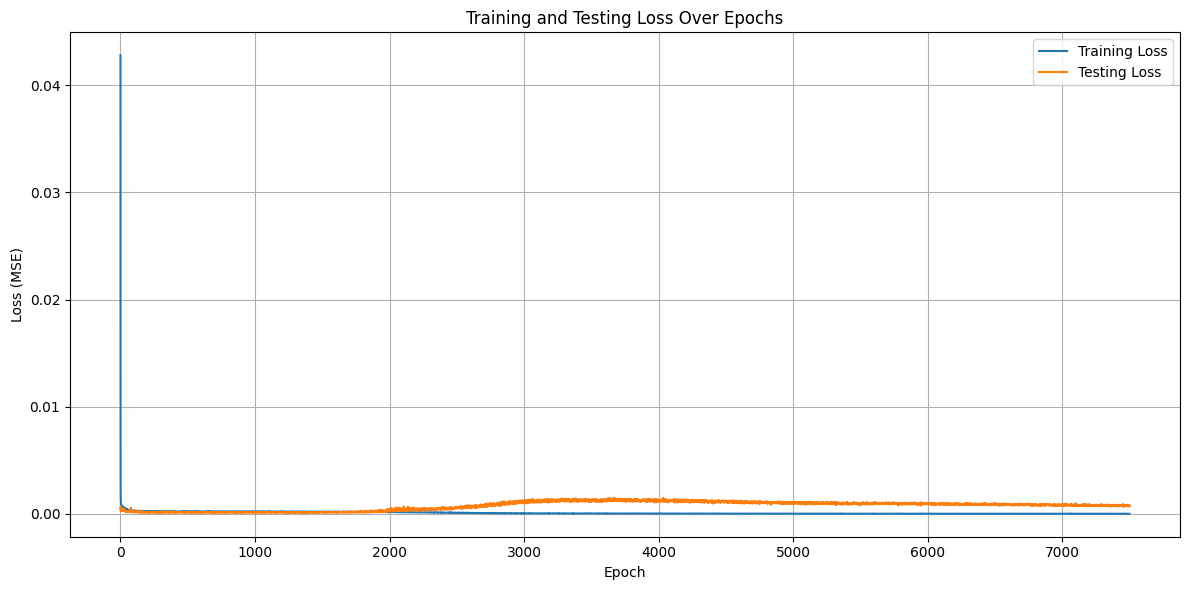

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# For reproducibility
np.random.seed(42)

# Download data
print("Downloading INFOSYS historical data...")
df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")

if df.empty:
    print("ERROR: No data returned.")
    exit()

# Use only Close price
df = df[["Close"]]
df.reset_index(inplace=True)
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values("Date", inplace=True)

# Split train/test
train_df = df[df["Date"] <= date(2025, 5, 31)]
test_df = df[(df["Date"] >= date(2025, 6, 1)) & (df["Date"] <= date(2025, 7, 1))]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Determine split index
# The split index needs to account for the sequence length offset
# It should align with the original train_df length minus the sequence length
# because X and y are created from the *entire* scaled_close data.
# The `split_index` should correspond to the number of sequences that can be formed
# entirely within the `train_df`'s date range.
# Let's recalculate `split_index` based on the number of training samples after sequence creation.
# The number of samples in X_train should correspond to the number of `y` values
# that fall within the `train_df`'s date range, considering the `sequence_length` offset.

# Find the index in the original `df` where the test data starts
# This is `len(train_df)` in the original `df` indices.
# However, `X` and `y` are shifted by `sequence_length`.
# So, the split_index for X and y should be `len(train_df) - sequence_length`.
# This ensures X_train contains sequences ending up to the last day of train_df.
split_index = len(train_df) - sequence_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
test_dates = df["Date"].values[sequence_length + split_index:] # Dates corresponding to y_test

# Build LSTM model
model = Sequential()
# Changed SimpleRNN to LSTM
model.add(LSTM(50, activation="tanh", input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train model with validation on test data
print("Training model for 7500 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=7500,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    # Check if the user_date is present in the test_dates array
    if user_date not in test_dates:
        print("Date not in test data. Please choose a date from the available test dates.")
        print(f"Available test dates: {test_dates[0]} to {test_dates[-1]}")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1-1660647185.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Streaming output truncated to the last 5000 lines.
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8181e-06 - val_loss: 3.8885e-04
Epoch 7511/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1648e-06 - val_loss: 3.7179e-04
Epoch 7512/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2200e-06 - val_loss: 4.0986e-04
Epoch 7513/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3753e-06 - val_loss: 3.9421e-04
Epoch 7514/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0854e-06 - val_loss: 4.1113e-04
Epoch 7515/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2554e-06 - val_loss: 3.7796e-04
Epoch 7516/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6549e-06 - val_loss: 3.8984e-04
Epoch 7517/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.9413e-06 - val_loss: 4.0821e-04
Epoch 7518/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.7276e-06 - val_loss: 3.4333e-04
Epoch 7519/10000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3364e-05 - val_

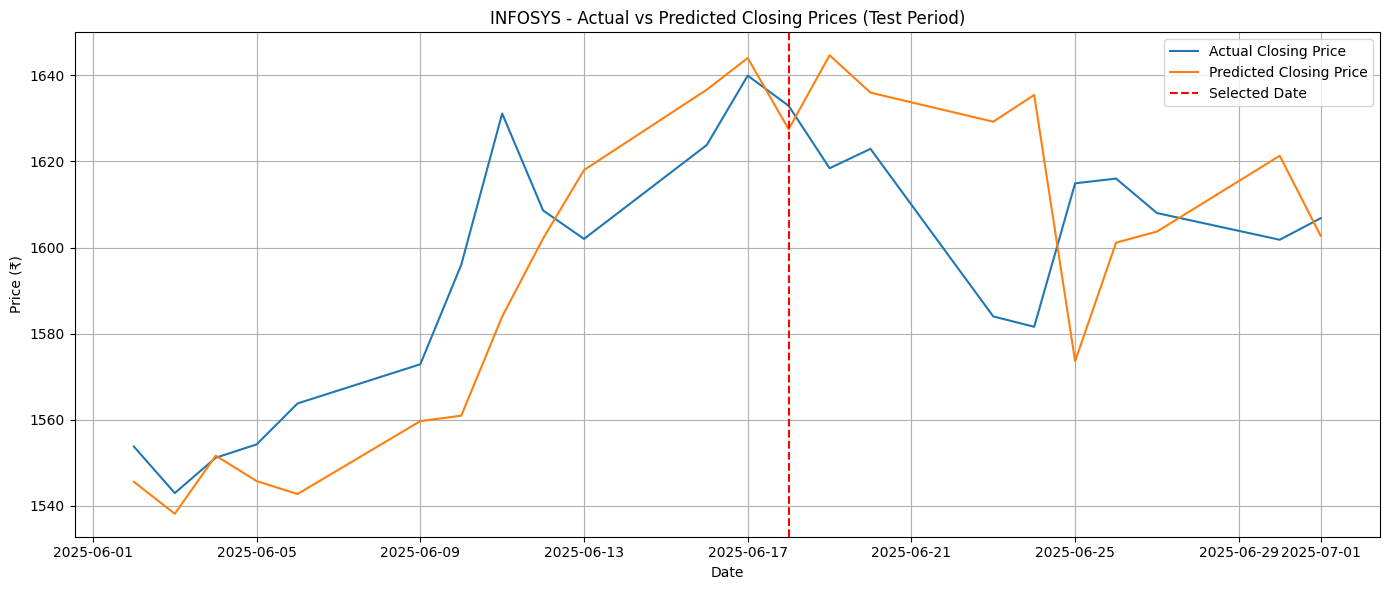

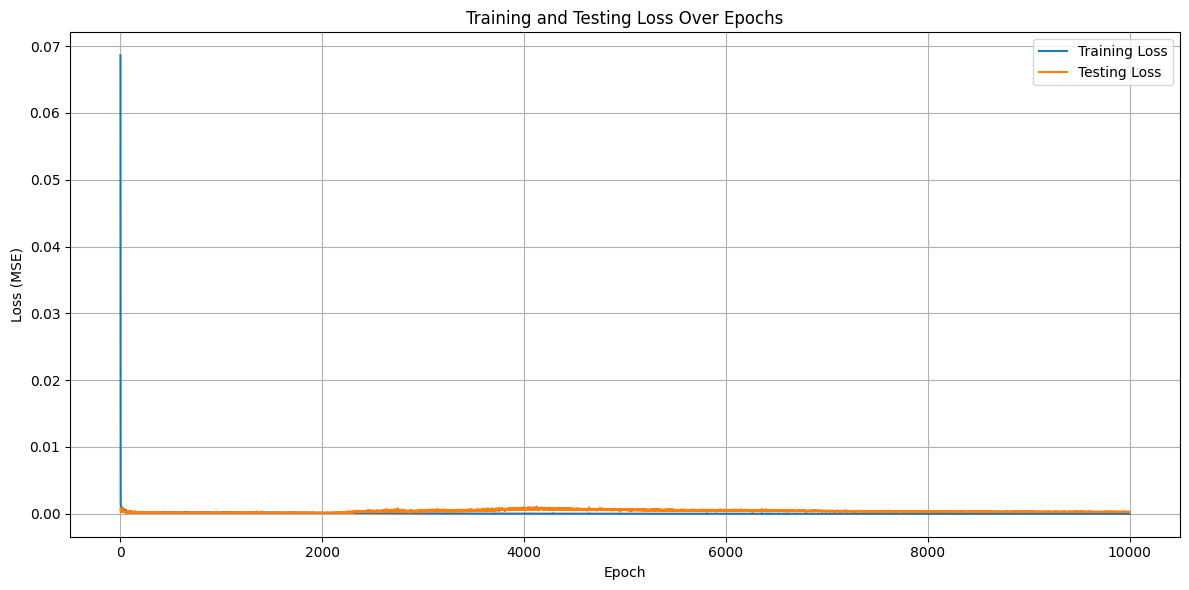

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# For reproducibility
np.random.seed(42)

# Download data
print("Downloading INFOSYS historical data...")
df = yf.download("INFY.NS", start="2020-01-01", end="2025-07-02")

if df.empty:
    print("ERROR: No data returned.")
    exit()

# Use only Close price
df = df[["Close"]]
df.reset_index(inplace=True)
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values("Date", inplace=True)

# Split train/test
train_df = df[df["Date"] <= date(2025, 5, 31)]
test_df = df[(df["Date"] >= date(2025, 6, 1)) & (df["Date"] <= date(2025, 7, 1))]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# Create sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Determine split index
# The split index needs to account for the sequence length offset
# It should align with the original train_df length minus the sequence length
# because X and y are created from the *entire* scaled_close data.
# The `split_index` should correspond to the number of sequences that can be formed
# entirely within the `train_df`'s date range.
# Let's recalculate `split_index` based on the number of training samples after sequence creation.
# The number of samples in X_train should correspond to the number of `y` values
# that fall within the `train_df`'s date range, considering the `sequence_length` offset.

# Find the index in the original `df` where the test data starts
# This is `len(train_df)` in the original `df` indices.
# However, `X` and `y` are shifted by `sequence_length`.
# So, the split_index for X and y should be `len(train_df) - sequence_length`.
# This ensures X_train contains sequences ending up to the last day of train_df.
split_index = len(train_df) - sequence_length
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
test_dates = df["Date"].values[sequence_length + split_index:] # Dates corresponding to y_test

# Build LSTM model
model = Sequential()
# Changed SimpleRNN to LSTM
model.add(LSTM(50, activation="tanh", input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train model with validation on test data
print("Training model for 10000 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=10000,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predict on test data
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Training Set Metrics ---
train_pred_scaled = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred_scaled)
train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

mse_train = np.mean((train_pred - train_actual)**2)
mae_train = np.mean(abs(train_pred - train_actual))
mape_train = np.mean(abs(train_pred - train_actual) / train_actual) * 100
accuracy_train = 100 - mape_train
avg_train_price = np.mean(train_actual)
mse_train_percent = (mse_train / avg_train_price) * 100
mae_train_percent = (mae_train / avg_train_price) * 100

# --- Test Set Metrics ---
mse = np.mean((predicted - actual) ** 2)
mae = np.mean(abs(predicted - actual))
avg_price = np.mean(actual)
mse_percent = (mse / avg_price) * 100
mae_percent = (mae / avg_price) * 100
mape = np.mean(abs(predicted - actual) / actual) * 100
accuracy = 100 - mape

# Print metrics
print("\n========== Training Set Metrics ==========")
print(f"MSE: {mse_train:.4f} ({mse_train_percent:.4f}% of avg price)")
print(f"MAE: {mae_train:.4f} ({mae_train_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy_train:.2f}%")

print("\n========== Test Set Metrics ==========")
print(f"MSE: {mse:.4f} ({mse_percent:.4f}% of avg price)")
print(f"MAE: {mae:.4f} ({mae_percent:.4f}% of avg price)")
print(f"Accuracy: {accuracy:.2f}%")
print("=========================================\n")

# Prompt user for date
while True:
    user_input = input("Enter a date between 2025-06-01 and 2025-07-01 (YYYY-MM-DD): ").strip()
    try:
        user_date = datetime.datetime.strptime(user_input, "%Y-%m-%d").date()
    except ValueError:
        print("Invalid format. Try again.")
        continue
    if not (date(2025, 6, 1) <= user_date <= date(2025, 7, 1)):
        print("Date out of range.")
        continue
    # Check if the user_date is present in the test_dates array
    if user_date not in test_dates:
        print("Date not in test data. Please choose a date from the available test dates.")
        print(f"Available test dates: {test_dates[0]} to {test_dates[-1]}")
        continue
    break

# Find index
idx = np.where(test_dates == user_date)[0][0]
pred_price = predicted[idx][0]
act_price = actual[idx][0]
error_pct = abs(pred_price - act_price) / act_price * 100

# Display prediction
print(f"\nFor {user_date}:")
print(f"Predicted closing price: ₹{pred_price:.2f}")
print(f"Actual closing price: ₹{act_price:.2f}")
print(f"Absolute error: {error_pct:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual, label="Actual Closing Price")
plt.plot(test_dates, predicted, label="Predicted Closing Price")
plt.axvline(x=np.datetime64(user_date), color="red", linestyle="--", label="Selected Date")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("INFOSYS - Actual vs Predicted Closing Prices (Test Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.title("Training and Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
